# Rede convolucional para identificação de células de tecido sanguíneo a partir de imagens de microscópio

Fonte de dados: https://data.mendeley.com/datasets/snkd93bnjr/1

Rede Neural Convolucional estudada: **Xception**

Última modificação: 07/08/2021

In [1]:
# Bibliotecas Python necessárias e outras
import os
from google.colab import files
import zipfile
import numpy as np
import pandas as pd
import cv2
# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
# Sklearn
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, classification_report

import tensorflow as tf
# Keras
import keras
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import image_dataset_from_directory
from keras.models import Sequential, Model 
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.data_utils import get_file

## Leitura dos dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Criação de um diretório "dataset", o zip é colocado nesse dataset
os.makedirs("/content/dataset_zip/", exist_ok=True)

In [4]:
!cp /content/drive/MyDrive/TCC2020/blood/dados_bood/dataset_zip.zip /content/

In [ ]:
!unzip /content/dataset_zip.zip

In [6]:
# TESTAR
!mv /content/train /content/dataset_zip/
!mv /content/test /content/dataset_zip/

In [7]:
# Diretorio com imagens de treino de eosinofilo
train1 = os.path.join('/content/dataset_zip/train/EOSINOPHIL')
# Diretorio com imagens de teste de EOSINOPHIL 
test1 = os.path.join('/content/dataset_zip/test/EOSINOPHIL')

# Diretorio com imagens de treino de linfocito
train2 = os.path.join('/content/dataset_zip/train/LYMPHOCYTE')
# Diretorio com imagens de teste de linfocito 
test2 = os.path.join('/content/dataset_zip/test/LYMPHOCYTE')

# Diretorio com imagens de treino de monocito
train3 = os.path.join('/content/dataset_zip/train/MONOCYTE')
# Diretorio com imagens de teste de monocito 
test3 = os.path.join('/content/dataset_zip/test/MONOCYTE')

# Diretorio com imagens de treino de neutrofilo
train4 = os.path.join('/content/dataset_zip/train/NEUTROPHIL')
# Diretorio com imagens de teste de neutrofilo 
test4 = os.path.join('/content/dataset_zip/test/NEUTROPHIL')

# Diretorio com imagens de treino de basofilos
train5 = os.path.join('/content/dataset_zip/train/BASOPHIL')
# Diretorio com imagens de teste de neutrofilo 
test5 = os.path.join('/content/dataset_zip/test/BASOPHIL')



print('total train eosinofilo:', len(os.listdir(train1)))
print('total test eosinofilo:', len(os.listdir(test1)))


print('total train linfocito:', len(os.listdir(train2)))
print('total test linfocito:', len(os.listdir(test2)))

print('total train monocito:', len(os.listdir(train3)))
print('total test monocito:', len(os.listdir(test3)))

print('total train neutrofilo:', len(os.listdir(train4)))
print('total test neutrofilo:', len(os.listdir(test4)))


print('total train basofilo:', len(os.listdir(train5)))
print('total test basofilo:', len(os.listdir(test5)))

total train eosinofilo: 2493
total test eosinofilo: 624
total train linfocito: 971
total test linfocito: 243
total train monocito: 1136
total test monocito: 284
total train neutrofilo: 2663
total test neutrofilo: 666
total train basofilo: 974
total test basofilo: 244


## Pré-processamento dos dados

In [8]:
IMAGE_SIZE = (150,150)
TRAIN_DIR = '/content/dataset_zip/train'
TEST_DIR = '/content/dataset_zip/test'
BATCH_SIZE = 32

In [9]:
train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    validation_split = 0.2,
    subset='training',
    shuffle = True,
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=BATCH_SIZE,
    image_size = (150,150),
    seed=42
)
val_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    validation_split = 0.2,
    subset='validation',
    shuffle = True,
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=BATCH_SIZE,
    image_size = (150,150),
    seed=42
)

test_dataset = image_dataset_from_directory(
    TEST_DIR,    
    shuffle = False,
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size = 1,
    image_size = (150,150)
    
)

Found 8237 files belonging to 5 classes.
Using 6590 files for training.
Found 8237 files belonging to 5 classes.
Using 1647 files for validation.
Found 2061 files belonging to 5 classes.


## Xception com *Transfer Learning*
Baseado na documentação do keras: https://keras.io/guides/transfer_learning/#the-typical-transferlearning-workflow

In [ ]:
# Instanciando um modelo básico com pesos pré-treinados
base_model = Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
    pooling='max')

base_model.trainable = False

In [ ]:
# Criação de um novo modelo 
inputs = base_model.input

x = preprocess_input(inputs)
x = base_model(inputs, training=False)
x = BatchNormalization()(x)

outputs = Dense(5, activation='softmax')(x) # Camada densa de classificação
base_model = Model(inputs, outputs)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
# Compilando o modelo
base_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
base_model.summary()

# Callback
#early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.1, patience=5, verbose = 1, mode='max', restore_best_weights = False)
# learning_rate_reduction = ReduceLROnPlateau(
#     monitor = 'val_accuracy', 
#     patience = 2, 
#     verbose = 1, 
#     factor = 0.3, 
#     min_lr = 0.0001)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 20,879,917
Trainable params: 14,341
Non-trainable params: 20,865,576
_________________________________________________________________


In [ ]:
# Verificar o learning_rage usado
import keras.backend as K
print(K.eval(base_model.optimizer.lr))

1e-04


In [ ]:
# Treino do modelo
%%time
history_base = base_model.fit(
    train_dataset,
    epochs=100,    
    validation_data=val_dataset
    )

Epoch 1/100
206/206 [==============================] - 42s 90ms/step - loss: 1.6233 - accuracy: 0.3005 - val_loss: 1.2942 - val_accuracy: 0.4627
Epoch 2/100
206/206 [==============================] - 15s 74ms/step - loss: 1.1784 - accuracy: 0.5312 - val_loss: 1.1414 - val_accuracy: 0.5549
Epoch 3/100
206/206 [==============================] - 16s 76ms/step - loss: 1.0628 - accuracy: 0.5863 - val_loss: 1.0895 - val_accuracy: 0.5914
Epoch 4/100
206/206 [==============================] - 16s 75ms/step - loss: 0.9951 - accuracy: 0.6113 - val_loss: 1.0588 - val_accuracy: 0.6138
Epoch 5/100
206/206 [==============================] - 16s 76ms/step - loss: 0.9435 - accuracy: 0.6444 - val_loss: 1.0268 - val_accuracy: 0.6327
Epoch 6/100
206/206 [==============================] - 16s 75ms/step - loss: 0.9030 - accuracy: 0.6639 - val_loss: 0.9979 - val_accuracy: 0.6448
Epoch 7/100
206/206 [==============================] - 15s 74ms/step - loss: 0.8680 - accuracy: 0.6708 - val_loss: 0.9739 - val_ac

In [ ]:
qtd_epochs = len(history_base.epoch)

### Visualização Accuracy / Loss

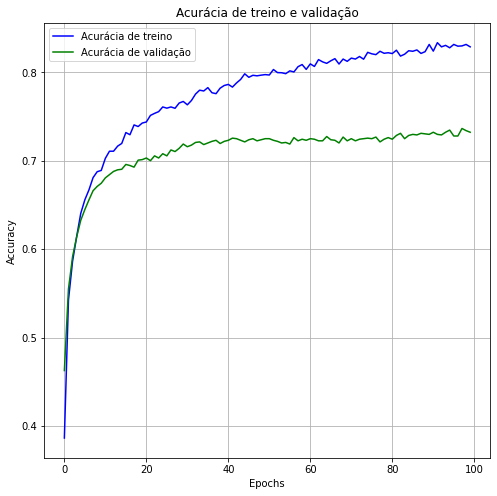

In [ ]:
plt.figure(figsize=(8, 8))
loss_train = history_base.history['accuracy']
loss_val = history_base.history['val_accuracy']
epochs = range(0,qtd_epochs)
plt.plot(epochs, loss_train, 'b', label='Acurácia de treino')
plt.plot(epochs, loss_val, 'g', label='Acurácia de validação')
plt.title('Acurácia de treino e validação')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

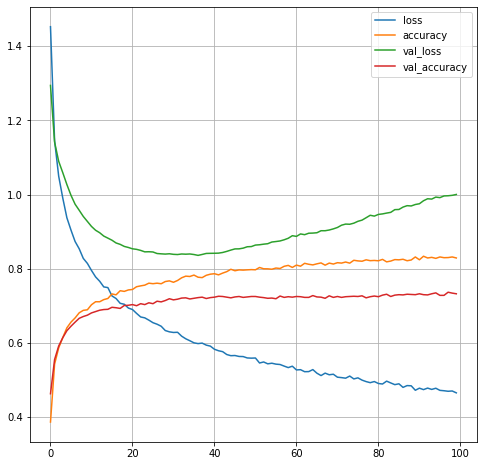

In [ ]:
# Try
pd.DataFrame(history_base.history).plot(figsize=(8,8))
plt.grid()
plt.show()

In [ ]:
# Avaliação dp desempenh da CNN
def plotAccucaria(history):
    epochs = [i for i in range(qtd_epochs)]
    fig , ax = plt.subplots(1,2)
    train_acc = history_base.history['accuracy']
    train_loss = history_base.history['loss']
    val_acc = history_base.history['val_accuracy']
    val_loss = history_base.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'b.-' , label = 'Acurácia de treinamento')
    ax[0].plot(epochs , val_acc , 'g.-' , label = 'Acurária de validação')
    ax[0].set_title('Acurácia de treinamento e validação')
    ax[0].legend()
    ax[0].set_xlabel("Épocas")
    ax[0].set_ylabel("Acurácia")
    ax[0].grid()
    ax[1].grid()
    ax[1].plot(epochs , train_loss , 'b.-' , label = 'Perda no treinamento')
    ax[1].plot(epochs , val_loss , 'r.-' , label = 'Perda na validação')
    ax[1].set_title('Perdas no treinamento e validação')
    ax[1].legend()
    ax[1].set_xlabel("Épocas")
    ax[1].set_ylabel("Perdas")
    
    plt.show()

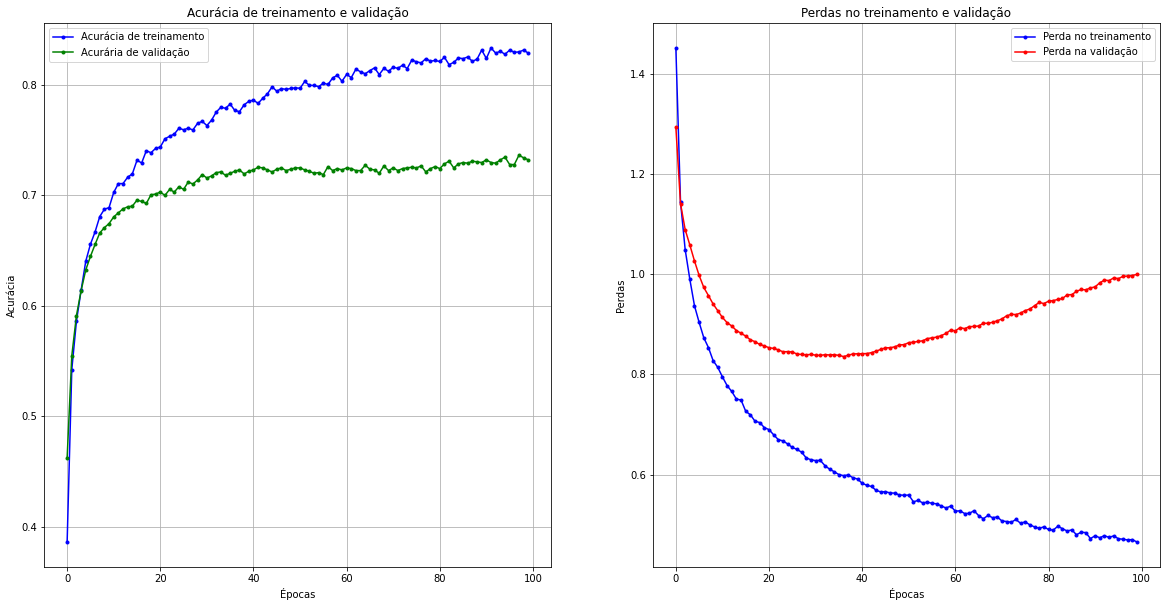

In [ ]:
# Usando a função plotAcuracia
plotAccucaria(history_base)

### Resultados - Com *Transfer Learning*

In [ ]:
# Evaluate
'''
Como estamos avaliando o modelo, devemos tratar o conjunto de validação como se fosse o 
conjunto de teste. Portanto, devemos amostrar as imagens no conjunto de validação
exatamente uma vez (se você está planejando avaliar, você precisa alterar
o tamanho do lote do gerador válido para 1
'''
#val_images.batch_size = 1
score = base_model.evaluate(test_dataset, verbose=1)
print("Perda do modelo = ", score[0])
print("Acurácia do modelo = ", score[1] *100, "%")

2061/2061 [==============================] - 16s 8ms/step - loss: 0.9493 - accuracy: 0.7302
Perda do modelo =  0.949337899684906
Acurácia do modelo =  73.0228066444397 %


In [ ]:
# Salvando o modelo
base_model.save_weights('xception_TL_epochs100_acc7302_without_overfeating.h5')

In [ ]:
CLASS_NAMES = list(test_dataset.class_names)
CLASS_NAMES

['BASOPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [ ]:
# Predição
predictions = np.array([])
labels = np.array([])

for x, y in test_dataset:
    predictions = np.concatenate([predictions, np.argmax(base_model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis = -1)])

cm = tf.math.confusion_matrix(labels, predictions).numpy()
acc = accuracy_score(labels, predictions)
clr = classification_report(labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

Test Accuracy: 73.023%


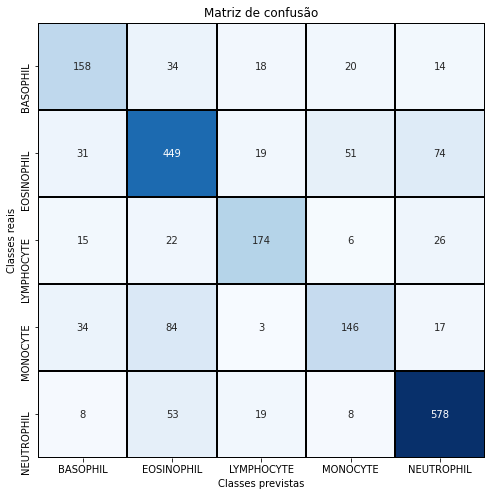

Relatório de classificação:
----------------------
               precision    recall  f1-score   support

    BASOPHIL       0.64      0.65      0.64       244
  EOSINOPHIL       0.70      0.72      0.71       624
  LYMPHOCYTE       0.75      0.72      0.73       243
    MONOCYTE       0.63      0.51      0.57       284
  NEUTROPHIL       0.82      0.87      0.84       666

    accuracy                           0.73      2061
   macro avg       0.71      0.69      0.70      2061
weighted avg       0.73      0.73      0.73      2061



In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False, linecolor = 'black', linewidth = 1)
plt.xticks(ticks= np.arange(5) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(5) + 0.5, labels=CLASS_NAMES)

plt.xlabel("Classes previstas")
plt.ylabel("Classes reais")

plt.title("Matriz de confusão")
plt.show()

print("Relatório de classificação:\n----------------------\n", clr)

## Arquitetura alternativa (baseada na Xception)

In [45]:
my_model = Sequential()
''' Minha Architectura '''
# Primeira bloco
my_model.add(Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
my_model.add(Conv2D(32 , (3,3), padding = 'same' , activation = 'relu'))
my_model.add(MaxPooling2D(pool_size = (2,2)))

# Segunda camada concolucional
my_model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
my_model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size = (2,2)))

# Terceira camada concolucional
my_model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
my_model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size = (2,2)))

# Quarta camada concolucional
my_model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
my_model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size = (2,2)))
my_model.add(Dropout(0.2))

# Quinta camada concolucional
my_model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
my_model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size = (2,2)))
my_model.add(Dropout(0.2))

# Camada (Fully Connected ) FC para classificar as features aprendidas
my_model.add(Flatten())
my_model.add(Dense(units = 1024 , activation = 'relu'))
my_model.add(Dropout(0.7))
my_model.add(Dense(units = 512 , activation = 'relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(units = 128 , activation = 'relu'))
my_model.add(Dropout(0.3))
my_model.add(Dense(units = 64 , activation = 'relu'))
my_model.add(Dropout(0.3))

# Camada de saída
my_model.add(Dense(units = 5 , activation = 'softmax'))

In [46]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [47]:
# Compile
%%time
my_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
my_model.summary()

# Callback
#checkpoint = ModelCheckpoint(filepath='/content/model_propose_20210807_epochs20.hdf5', save_best_only=True, save_weights_only=False)
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = False)
# learning_rate_reduction = ReduceLROnPlateau(
#     monitor = 'val_accuracy', 
#     patience = 2, 
#     verbose = 1, 
#     factor = 0.3, 
#     min_lr = 0.0001)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
separable_conv2d_16 (Separab (None, 75, 75, 32)        1344      
_________________________________________________________________
separable_conv2d_17 (Separab (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 37, 37, 32)       

In [48]:
import keras.backend as K
print(K.eval(my_model.optimizer.lr))

1e-04


In [49]:
# Treinamento
%%time
history = my_model.fit(    
    train_dataset,
    epochs=100,
    validation_data=val_dataset
    )

Epoch 1/100
206/206 [==============================] - 23s 98ms/step - loss: 1.5333 - accuracy: 0.3146 - val_loss: 1.6020 - val_accuracy: 0.3127
Epoch 2/100
206/206 [==============================] - 19s 93ms/step - loss: 1.0391 - accuracy: 0.5446 - val_loss: 1.6880 - val_accuracy: 0.1475
Epoch 3/100
206/206 [==============================] - 19s 92ms/step - loss: 0.4996 - accuracy: 0.8215 - val_loss: 1.0662 - val_accuracy: 0.6491
Epoch 4/100
206/206 [==============================] - 19s 93ms/step - loss: 0.3170 - accuracy: 0.8933 - val_loss: 0.2548 - val_accuracy: 0.9162
Epoch 5/100
206/206 [==============================] - 19s 93ms/step - loss: 0.2068 - accuracy: 0.9335 - val_loss: 0.5422 - val_accuracy: 0.8197
Epoch 6/100
206/206 [==============================] - 19s 93ms/step - loss: 0.1728 - accuracy: 0.9441 - val_loss: 0.1433 - val_accuracy: 0.9514
Epoch 7/100
206/206 [==============================] - 19s 93ms/step - loss: 0.1070 - accuracy: 0.9672 - val_loss: 0.1415 - val_ac

In [51]:
qtd_epochs = len(history.epoch)

### Visualização Accuracy / Loss (Arquitetura Proposta)

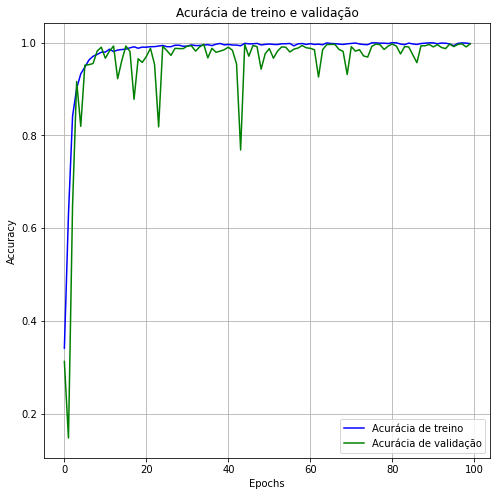

In [52]:
plt.figure(figsize=(8, 8))
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,qtd_epochs)
plt.plot(epochs, loss_train, 'b', label='Acurácia de treino')
plt.plot(epochs, loss_val, 'g', label='Acurácia de validação')
plt.title('Acurácia de treino e validação')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

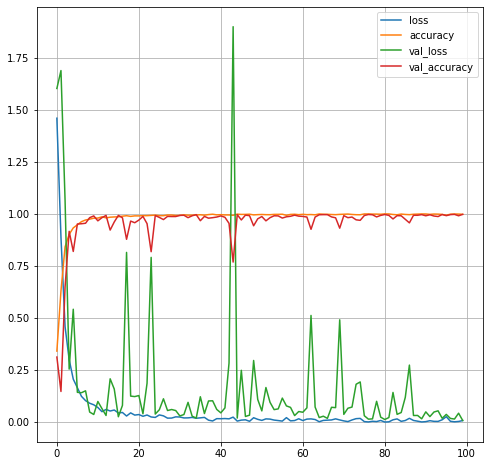

In [53]:
pd.DataFrame(history.history).plot(figsize=(8,8))
plt.grid()
plt.show()

In [54]:
# Avaliação dp desempenh da CNN
def plotAccucaria(history):
    epochs = [i for i in range(qtd_epochs)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'b.-' , label = 'Acurácia de treinamento')
    ax[0].plot(epochs , val_acc , 'g.-' , label = 'Acurária de validação')
    ax[0].set_title('Acurácia de treinamento e validação')
    ax[0].legend()
    ax[0].set_xlabel("Épocas")
    ax[0].set_ylabel("Acurácia")
    ax[0].grid()
    ax[1].grid()
    ax[1].plot(epochs , train_loss , 'b.-' , label = 'Perda no treinamento')
    ax[1].plot(epochs , val_loss , 'r.-' , label = 'Perda na validação')
    ax[1].set_title('Perdas no treinamento e validação')
    ax[1].legend()
    ax[1].set_xlabel("Épocas")
    ax[1].set_ylabel("Perdas")
    
    plt.show()

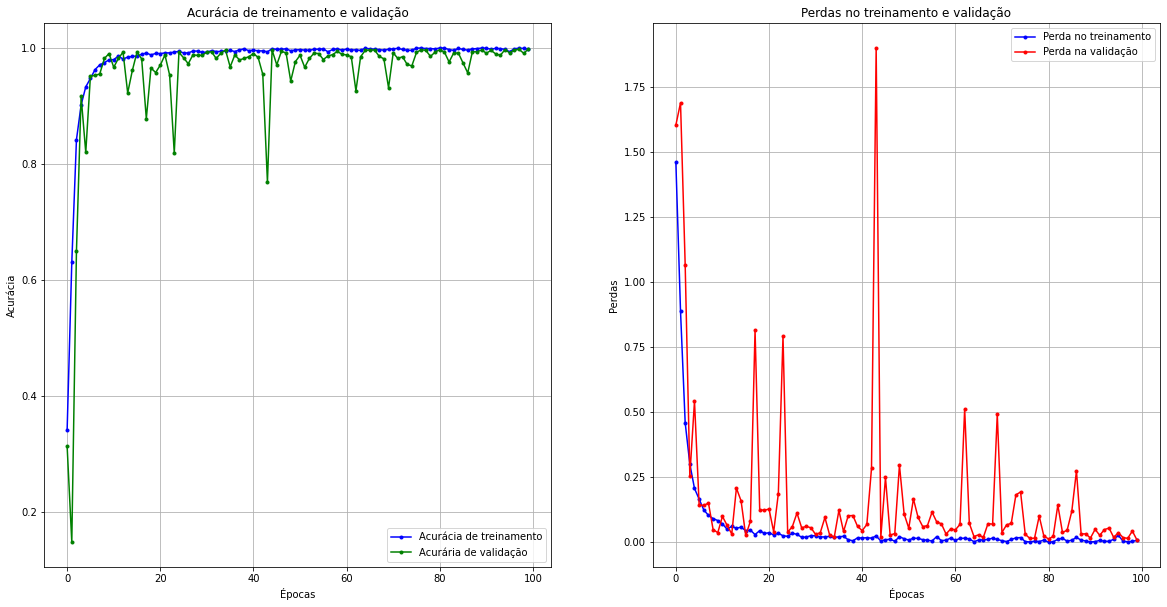

In [55]:
# Usando a função plotAcuracia
plotAccucaria(history)

### Resultados - Arquitetura Xception poposta

In [59]:
# Evaluate
'''
Como estamos avaliando o modelo, devemos tratar o conjunto de validação como se fosse o 
conjunto de teste. Portanto, devemos amostrar as imagens no conjunto de validação
exatamente uma vez (se você está planejando avaliar, você precisa alterar
o tamanho do lote do gerador válido para 1
'''
#val_images.batch_size = 1
score = my_model.evaluate(test_dataset, verbose=1)
print("Perda do modelo = ", score[0])
print("Acurácia do modelo = ", score[1] *100, "%")

2061/2061 [==============================] - 7s 3ms/step - loss: 0.0746 - accuracy: 0.9932
Perda do modelo =  0.07458944618701935
Acurácia do modelo =  99.32071566581726 %


In [60]:
# Salvando o modelo
my_model.save('xception_my_model_epochs100_acc9932.h5')

In [61]:
CLASS_NAMES = list(test_dataset.class_names)
CLASS_NAMES

['BASOPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [62]:
# Predição
predictions = np.array([])
labels = np.array([])

for x, y in test_dataset:
    predictions = np.concatenate([predictions, np.argmax(my_model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis = -1)])

cm = tf.math.confusion_matrix(labels, predictions).numpy()
acc = accuracy_score(labels, predictions)
clr = classification_report(labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

Test Accuracy: 99.321%


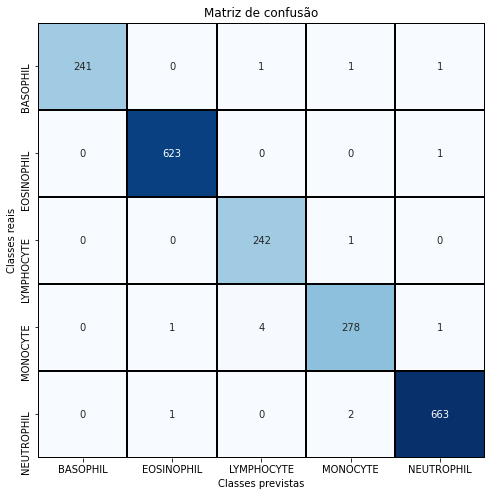

Relatório de classificação:
----------------------
               precision    recall  f1-score   support

    BASOPHIL       1.00      0.99      0.99       244
  EOSINOPHIL       1.00      1.00      1.00       624
  LYMPHOCYTE       0.98      1.00      0.99       243
    MONOCYTE       0.99      0.98      0.98       284
  NEUTROPHIL       1.00      1.00      1.00       666

    accuracy                           0.99      2061
   macro avg       0.99      0.99      0.99      2061
weighted avg       0.99      0.99      0.99      2061



In [63]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False, linecolor = 'black', linewidth = 1)
plt.xticks(ticks= np.arange(5) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(5) + 0.5, labels=CLASS_NAMES)

plt.xlabel("Classes previstas")
plt.ylabel("Classes reais")

plt.title("Matriz de confusão")
plt.show()

print("Relatório de classificação:\n----------------------\n", clr)

# Ambiente Computacional Utilizado
Com o Colab Pro, você tem prioridade no acesso a nossas GPUs mais rápidas. Por exemplo, algumas vezes você terá GPUs T4 ou P100, quando a maioria dos usuários do Colab recebem uma GPU K80, mais lenta. É possível ver qual é a GPU atribuída a qualquer momento, executando a célula a seguir.

In [32]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Aug  9 14:34:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    38W / 300W |   4395MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# É possível ver quanta memória há disponível a qualquer momento, executando o seguinte código.
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
